In [1]:
import sys
from os import getcwd, makedirs
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.spatial.distance import squareform
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings

In [3]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

---

### Select the HRF parameter with the highest $R^{2}$ score.

In [10]:
# mins = []
# maxs = []
# for roi in list_roi:
#     G_hat = dict_G_hat[roi].mean(axis=0)
#     min_ = G_hat.min()
#     max_ = G_hat.max()
#     mins.append(min_)
#     maxs.append(max_)
# plt.plot(range(8),mins)
# plt.plot(range(8),maxs)

In [11]:
df_r2 = pd.read_csv(
    join(su.get_dir_result(),'mean_y_across_run/r2_score.tsv'),
    sep='\t', header=0
)
df_r2

,subj,sess,roi,param,r2
0,1,S,S1,"[4,14]",0.121725
1,1,R,S1,"[4,14]",0.246509
2,2,S,S1,"[4,14]",0.162380
3,2,R,S1,"[4,14]",0.374307
4,3,S,S1,"[4,14]",0.134179
...,...,...,...,...,...
1147,12,R,SPLp,"[9,19]",0.148224
1148,13,S,SPLp,"[9,19]",0.072790
1149,13,R,SPLp,"[9,19]",0.124870
1150,14,S,SPLp,"[9,19]",0.106808


In [12]:
df_tmp = df_r2.groupby(['subj','roi','param'], as_index=False).mean(['r2'])
df_param = df_tmp[df_tmp.r2==df_tmp.groupby(['subj','roi'])['r2'].transform('max')]
df_param.sort_values(by=['subj','roi'], ascending=[True,True])
# df_param['subj'] = df_param.subj.astype(str).str.zfill(2)
df_param

,subj,roi,param,r2
0,1,M1,"[4,14]",0.303799
7,1,PMd,"[5,15]",0.227037
13,1,PMv,"[5,15]",0.201462
19,1,S1,"[5,15]",0.252490
25,1,SMA,"[5,15]",0.139793
...,...,...,...,...
546,14,S1,"[4,14]",0.289173
552,14,SMA,"[4,14]",0.143694
559,14,SPLa,"[5,15]",0.208415
565,14,SPLp,"[5,15]",0.163065


---

## Load Data

In [13]:
glm = 1

In [14]:
reginfo = su.get_reginfo(subj='S01', glm=glm)
obs_des = {
    'cond_vec': reginfo.cond,
    'part_vec': reginfo.run
}
reginfo

,sn,run,cond,regIdx,seq,cue,reg
0,1,1,1,1,1,L,"(1,L)"
1,1,1,2,2,1,S,"(1,S)"
2,1,1,3,3,2,L,"(2,L)"
3,1,1,4,4,2,S,"(2,S)"
4,1,1,5,5,3,L,"(3,L)"
...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)"
60,1,8,5,61,3,L,"(3,L)"
61,1,8,6,62,3,S,"(3,S)"
62,1,8,7,63,4,L,"(4,L)"


In [15]:
list_nn = su.get_list_sn()

list_subj = []
for ss in ['S','R']:
    for nn in list_nn:
        list_subj.append(ss+nn)
print(list_subj)

['S01', 'S02', 'S03', 'S05', 'S06', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']


In [16]:
list_roi = simage.get_list_roi()
list_roi

array(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], dtype='<U4')

### Organizing data by ROI

In [17]:
dict_Y = {}
for roi in tqdm(list_roi):
    tmp = []
    for ss, subj in enumerate(list_subj):
        sidx = int(subj[1:])
        param = df_param[(df_param.subj==sidx)&(df_param.roi==roi)].param.values[0]
        beta_whiten = simage.get_prewhitened_beta(subj=subj,glm=glm,region=roi,param=param)
        dataset = pcm.dataset.Dataset(
            measurements=beta_whiten,
            obs_descriptors=obs_des
        )
        tmp.append(dataset)
    dict_Y[roi] = tmp
dict_Y.keys()

100%|█████████████████████████████████████████████| 8/8 [00:18<00:00,  2.34s/it]


dict_keys(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'])

---

## Decoding Accuracy

In [18]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'GLM_%d.classification'%glm)

makedirs(dir_work, exist_ok=True)

In [19]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [20]:
nruns = 8
samples_per_run = 8

### 1. Support Vector Machine (Sequence)

In [21]:
labels = reginfo.seq.values
groups = reginfo.run.values
print(len(labels), labels)
print(len(groups), groups)

64 [1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3
 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4]
64 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8]


In [22]:
from sklearn.svm import SVC

In [23]:
lines = []
for roi in list_roi:
    for sn, subj in enumerate(tqdm(list_subj)):
        sess = subj[0]
        nn = subj[1:]
        
        X = dict_Y[roi][sn].measurements
        nsamples, nfeatures = X.shape
        
        model = SVC(kernel='linear', C=1.0)
        scaler = StandardScaler()
        
        logo = LeaveOneGroupOut()
        nsplits = logo.get_n_splits(X=X, y=labels, groups=groups)
    
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, labels, groups)):
            # print('--- Fold %d/%d ---'%(fold_idx+1,nsplits))
        
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]
        
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            model.fit(X_train_scaled, y_train)
        
            y_pred = model.predict(X_test_scaled)
        
            accuracy = accuracy_score(y_test, y_pred)
            lines.append(
                {'roi':roi,'sess':sess,'subj':nn,'run':fold_idx+1,'accuracy':accuracy}
            )
df_svm = pd.DataFrame(lines)
df_svm

100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 43.81it/s]


,roi,sess,subj,run,accuracy
0,S1,S,01,1,0.250
1,S1,S,01,2,0.500
2,S1,S,01,3,0.250
3,S1,S,01,4,0.250
4,S1,S,01,5,0.375
...,...,...,...,...,...
1531,SPLp,R,14,4,0.500
1532,SPLp,R,14,5,0.500
1533,SPLp,R,14,6,0.750
1534,SPLp,R,14,7,0.125


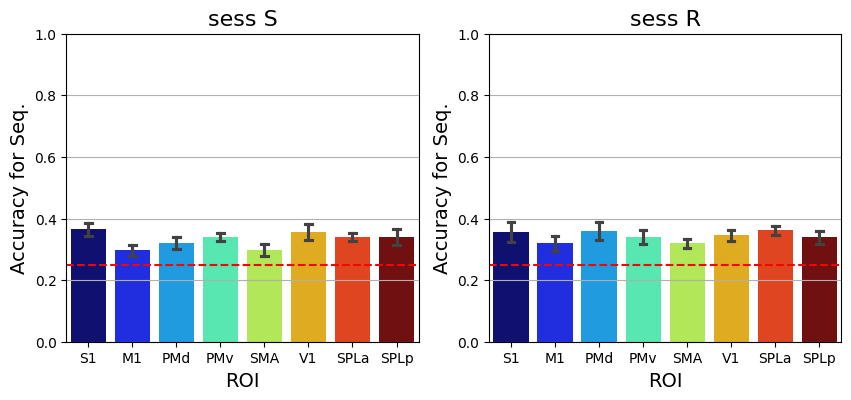

In [24]:
cmap = cm.jet.resampled(8)
data = df_svm.groupby(['roi','sess','subj'], as_index=False).mean()

fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ii, sess in enumerate(['S','R']):
    ax = axs[ii]
    g = sns.barplot(
        data=data[data.sess==sess],
        x='roi', order=list_roi,
        y='accuracy',
        hue='roi', hue_order=list_roi,
        errorbar='se', capsize=0.15,
        palette=[cmap(i) for i in range(cmap.N)],
        ax=ax
    )
    g.axhline(y=0.25, color='red', linestyle='--')
    g.set_ylim(0,1.0)
    g.grid(axis='y')
    g.set_ylabel('Accuracy for Seq.', fontsize=14)
    g.set_xlabel('ROI', fontsize=14)
    g.set_title('sess %s'%sess, fontsize=16)

S1 S t(11)=5.1024, p=3.428e-04(***)
S1 R t(11)=3.3242, p=6.780e-03(**)
M1 S t(11)=2.5690, p=2.609e-02(*)
M1 R t(11)=2.8871, p=1.478e-02(*)
PMd S t(11)=3.7607, p=3.151e-03(**)
PMd R t(11)=3.8694, p=2.611e-03(**)
PMv S t(11)=7.1134, p=1.959e-05(****)
PMv R t(11)=3.9462, p=2.287e-03(**)
SMA S t(11)=2.4277, p=3.354e-02(*)
SMA R t(11)=5.0513, p=3.713e-04(***)
V1 S t(11)=4.0723, p=1.844e-03(**)
V1 R t(11)=5.0583, p=3.672e-04(***)
SPLa S t(11)=7.2410, p=1.663e-05(****)
SPLa R t(11)=7.7230, p=9.117e-06(****)
SPLp S t(11)=3.4426, p=5.500e-03(**)
SPLp R t(11)=4.5070, p=8.909e-04(***)


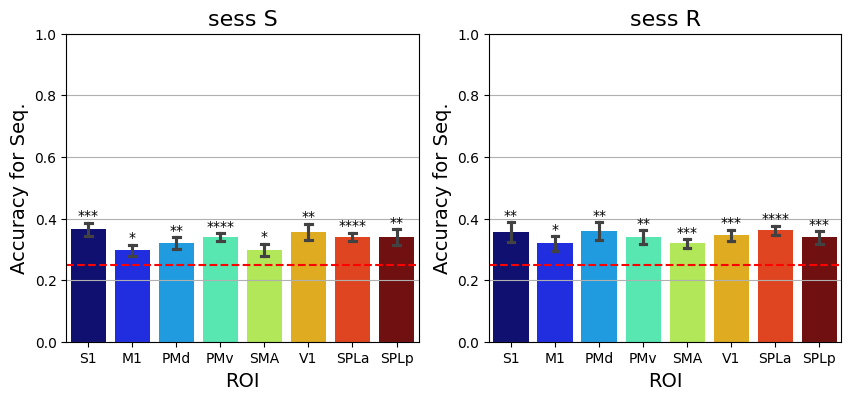

In [25]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    for jj, sess in enumerate(['S','R']):
        ax = axs[jj]
        a = data[(data.roi==roi)&(data.sess==sess)]['accuracy'].astype(float)
        res = ttest_1samp(a, popmean=0.25)
        if res.pvalue < 0.05:
            print(roi, sess, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
            x = ii
            y = a.mean()+a.sem()
            ax.text(
                x=x, y=y,
                s=su.convert_pval_to_star(res.pvalue), fontsize=10,
                ha='center', va='bottom'
            )
fig

### 2. Support Vector Machine (Cue)

In [26]:
labels = reginfo.cue.values
groups = reginfo.run.values
print(len(labels), labels)
print(len(groups), groups)

64 ['L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S'
 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S'
 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S'
 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S']
64 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8]


In [27]:
lines = []
for roi in list_roi:
    for sn, subj in enumerate(tqdm(list_subj)):
        sess = subj[0]
        nn = subj[1:]
        
        X = dict_Y[roi][sn].measurements
        nsamples, nfeatures = X.shape
        
        model = SVC(kernel='linear', C=1.0)
        scaler = StandardScaler()
        
        logo = LeaveOneGroupOut()
        nsplits = logo.get_n_splits(X=X, y=labels, groups=groups)
    
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, labels, groups)):
            # print('--- Fold %d/%d ---'%(fold_idx+1,nsplits))
        
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]
        
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            model.fit(X_train_scaled, y_train)
        
            y_pred = model.predict(X_test_scaled)
        
            accuracy = accuracy_score(y_test, y_pred)
            lines.append(
                {'roi':roi,'sess':sess,'subj':nn,'run':fold_idx+1,'accuracy':accuracy}
            )
df_svm = pd.DataFrame(lines)
df_svm

100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 58.06it/s]


,roi,sess,subj,run,accuracy
0,S1,S,01,1,0.625
1,S1,S,01,2,0.625
2,S1,S,01,3,0.500
3,S1,S,01,4,0.500
4,S1,S,01,5,0.500
...,...,...,...,...,...
1531,SPLp,R,14,4,1.000
1532,SPLp,R,14,5,0.875
1533,SPLp,R,14,6,1.000
1534,SPLp,R,14,7,1.000


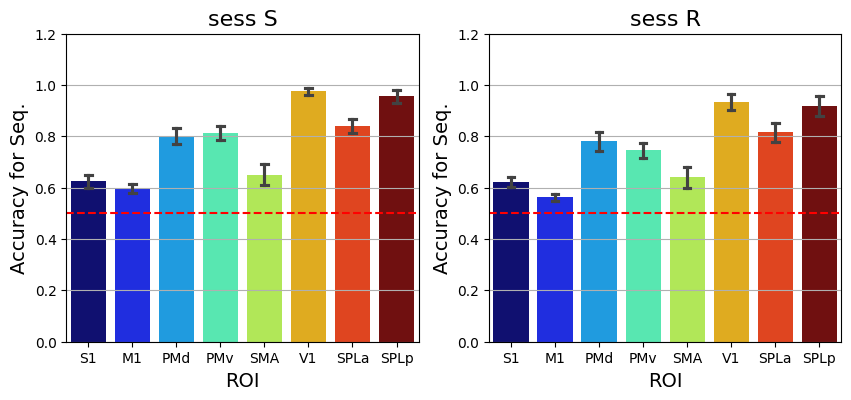

In [28]:
cmap = cm.jet.resampled(8)
data = df_svm.groupby(['roi','sess','subj'], as_index=False).mean()

fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ii, sess in enumerate(['S','R']):
    ax = axs[ii]
    g = sns.barplot(
        data=data[data.sess==sess],
        x='roi', order=list_roi,
        y='accuracy',
        hue='roi', hue_order=list_roi,
        errorbar='se', capsize=0.15,
        palette=[cmap(i) for i in range(cmap.N)],
        ax=ax
    )
    g.axhline(y=0.5, color='red', linestyle='--')
    g.set_ylim(0,1.2)
    g.grid(axis='y')
    g.set_ylabel('Accuracy for Seq.', fontsize=14)
    g.set_xlabel('ROI', fontsize=14)
    g.set_title('sess %s'%sess, fontsize=16)

S1 S t(11)=4.9556, p=4.318e-04(***)
S1 R t(11)=6.3239, p=5.647e-05(****)
M1 S t(11)=5.6070, p=1.586e-04(***)
M1 R t(11)=4.3425, p=1.170e-03(**)
PMd S t(11)=9.9073, p=8.114e-07(****)
PMd R t(11)=7.6023, p=1.057e-05(****)
PMv S t(11)=11.3827, p=1.998e-07(****)
PMv R t(11)=8.2572, p=4.829e-06(****)
SMA S t(11)=3.6250, p=3.991e-03(**)
SMA R t(11)=3.4778, p=5.169e-03(**)
V1 S t(11)=32.8866, p=2.452e-12(****)
V1 R t(11)=13.5424, p=3.326e-08(****)
SPLa S t(11)=12.9518, p=5.289e-08(****)
SPLa R t(11)=8.6213, p=3.186e-06(****)
SPLp S t(11)=18.1124, p=1.544e-09(****)
SPLp R t(11)=11.1317, p=2.508e-07(****)


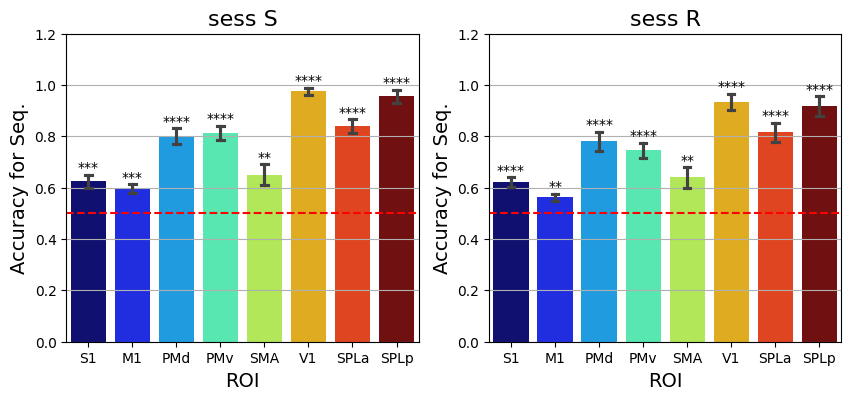

In [29]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    for jj, sess in enumerate(['S','R']):
        ax = axs[jj]
        a = data[(data.roi==roi)&(data.sess==sess)]['accuracy'].astype(float)
        res = ttest_1samp(a, popmean=0.5)
        if res.pvalue < 0.05:
            print(roi, sess, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
            x = ii
            y = a.mean()+a.sem()
            ax.text(
                x=x, y=y,
                s=su.convert_pval_to_star(res.pvalue), fontsize=10,
                ha='center', va='bottom'
            )
fig

### 3. Linear Discriminant Analysis

In [30]:
# fig.savefig(
#     join(dir_work,'glm_%d.G_hat.ROIs.correlation.png'%glm),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

---